### Diffusion
 - 한번에 그림을 생성하는 방식으로는 부드러운 이미지를 만드는 것이 어려웠다.
 - 그래서 이미지를 서서히 복구하는 방식으로 학습을 시키면 어떨까? 라고 생각하게 됐다.
 - 즉 데이터를 조금씩 망가뜨린 후 (노이즈를 추가함으로써) 그것을 복원하는 방향으로 학습하면 어떨까?
 - 위 아이디어를 기반으로 나온 것이 바로 Diffusion이다.
 - 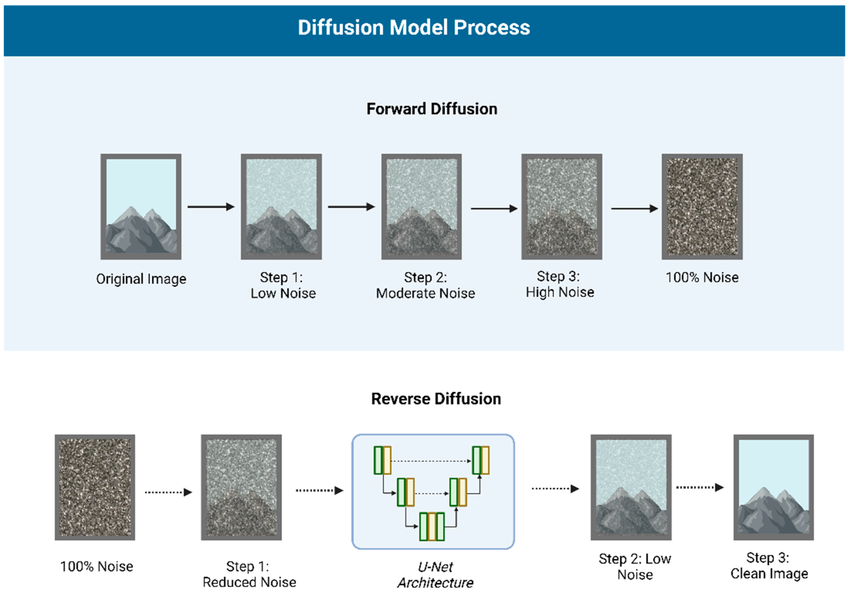

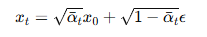

한번에 바로 이 공식을 따라서 노이즈를 추가 할 수 있다.

이러한 과정을 닫힌 과정 (조금씩 추가하나, 한번에 추가하나 동일하다.) 이라고 한다.

닫힌 과정은 학습 과정에서 대체로 안정적이다.

닫힌 형태 덕분에, 모델은 복잡한 생성이 아니라 임의 시점의 노이즈 제거만 배우면 된다.

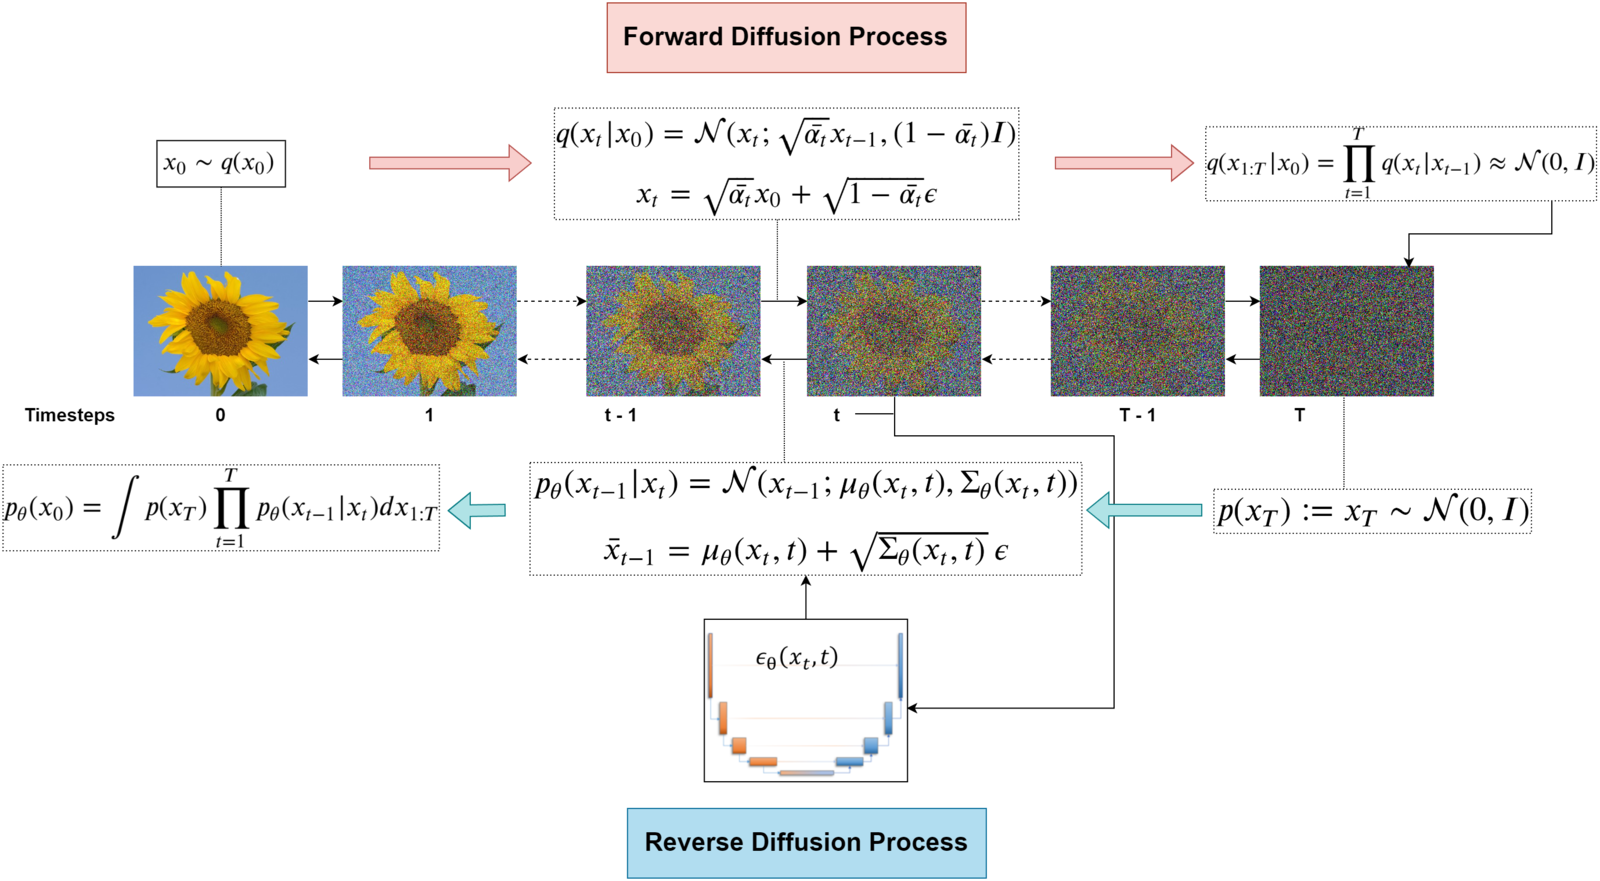

이 과정을 거치면서 섞여있는 노이즈가 무엇이였는지 예측한다.

모델은 이미지를 예측하는 것이 아니라,
현재 상태에 섞인 노이즈를 예측한다.

그렇기 때문에 학습이 꽤 안정적이다.

생성 할 때는

노이즈를 가져 온 뒤

t -> 1로 되돌리는 과정을 수행한다.

이 과정을 통해서 원래 상태로 되돌리면, 그림 생성이 된다.

노이즈를 여러번 걷어내야 하기 때문에, 생성이 느리지만, 대신 결과는 매우 안정적이다.

Diffusion은 Text에서의 Transformer와 같이 새로운 방식은 없고,

Step 수를 줄이기 (빠르게 생성, DDIM)

일관성을 지키기, Text 입력을 같이 받기, (Stable Diffusion)

도메인을 같이 가져가게 하기

세부 오류나 품질을 더 좋게 하는 방향으로

등의 연구가 이루어지고 있다.

### GAN은 학습 방식일 뿐...
 - Diffusion 과 상호 배타적이지 않다.
 - Generator 가 Diffusion으로 학습 할 수도 있다.
 - 실제로 이런 시도도 해 볼 수 있고...
 - 다만 굳이 GAN으로 Diffusion을 학습 할 필요는 없고, 학습이 불안정해지기만 하기 때문에 잘 쓰지는 않는다.

### U-NET
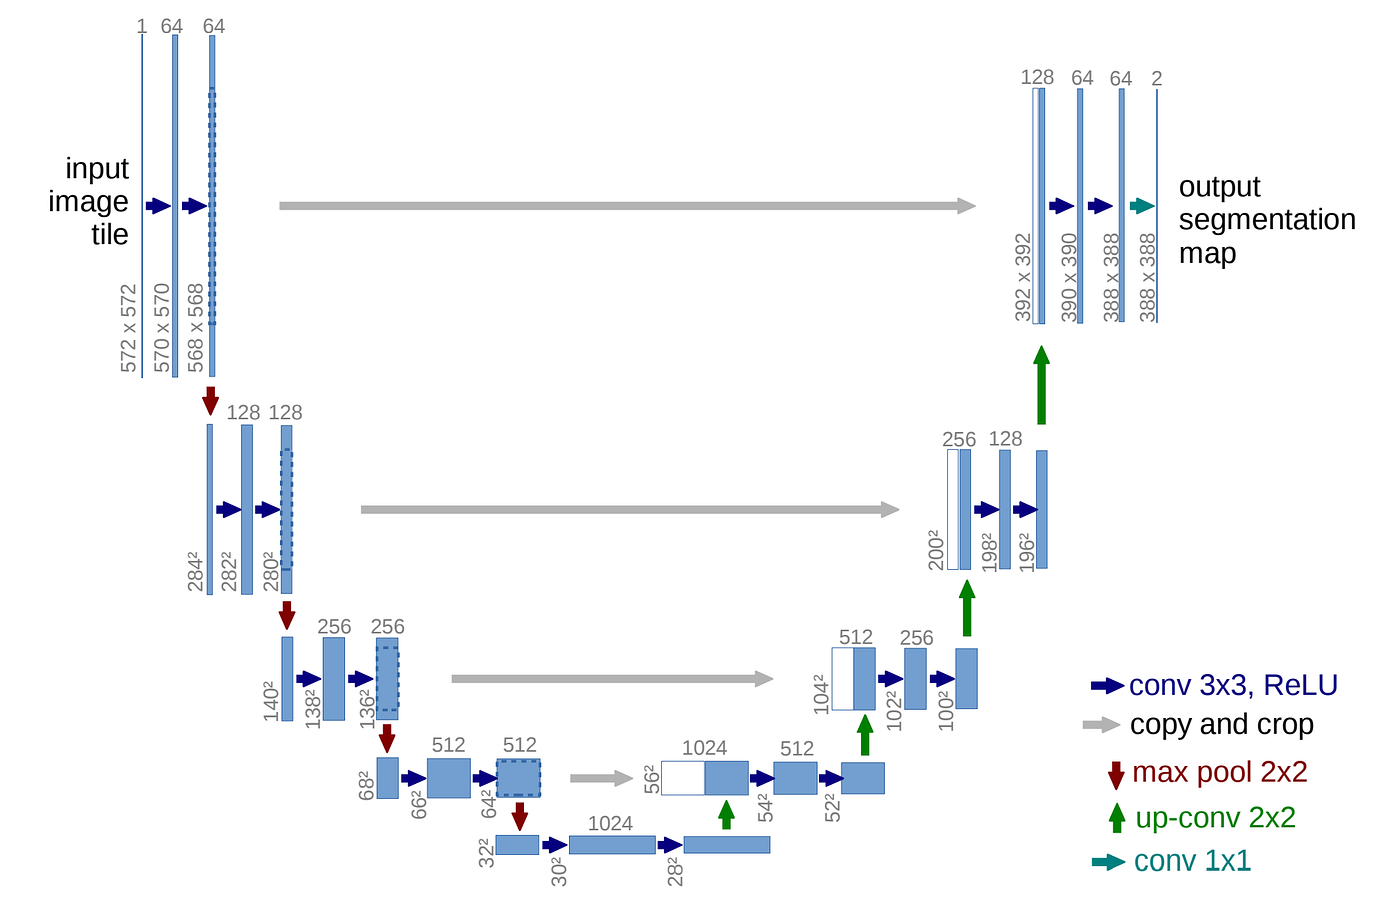

모델 구조가 이렇게 U 처럼 그릴 수 있어서... U-NET 이다.

U-NET 의 Encoder 에서는 해상도를 줄이고 채널을 늘려서 전체 그림을 본다.

Decoder 에서는 해상도를 늘리고, 채널을 줄여서 위의 Encoder에서 만든 Contect를 보고 이미지를 복원한다.

Diffusion의 노이즈 제거 모델은 U-NET을 많이 사용한다.

In [1]:
import math
import os
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device: cuda


torch.Size([128, 1, 28, 28]) -1.0 1.0


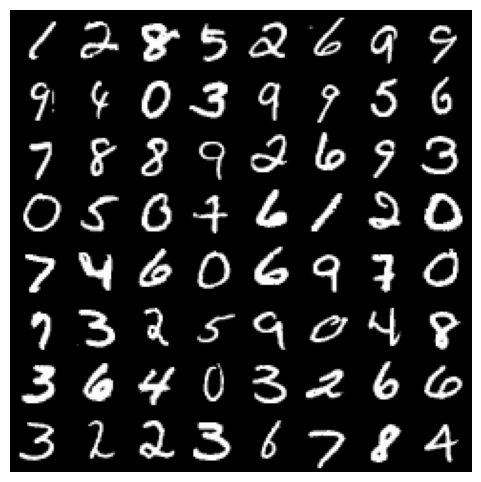

In [2]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),                # [0,1]
    transforms.Lambda(lambda x: x*2-1),    # [-1,1] 로 변환
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=False 
)

# 샘플 확인
x0, _ = next(iter(train_loader))
print(x0.shape, x0.min().item(), x0.max().item())

grid = utils.make_grid((x0[:64] + 1) / 2, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock(nn.Module):
    """
    Residual Block with time embedding injection.

    x:     (B, C, H, W)
    t_emb: (B, tdim)
    """
    def __init__(self, ch: int, tdim: int, dropout: float = 0.0, groups: int = 8):
        super().__init__()

        self.norm1 = nn.GroupNorm(groups, ch)
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(groups, ch)
        self.dropout = nn.Dropout(dropout)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)

        # time embedding -> channel bias (B, ch)
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, ch),
        )

    def forward(self, x: torch.Tensor, t_emb: torch.Tensor) -> torch.Tensor:
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return x + h


class Downsample(nn.Module):
    """
    Downsample by 2 using strided conv.
    (B, C, H, W) -> (B, C, H/2, W/2)
    """
    def __init__(self, ch: int):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, stride=2, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class Upsample(nn.Module):
    """
    Upsample by 2 using nearest interpolation + conv.
    (B, C, H, W) -> (B, C, 2H, 2W)
    """
    def __init__(self, ch: int):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)


In [4]:
def make_beta_schedule(T: int, schedule: str = "linear", beta_start=1e-4, beta_end=2e-2):
    if schedule == "linear":
        return torch.linspace(beta_start, beta_end, T)
    elif schedule == "cosine":
        s = 0.008
        steps = torch.arange(T + 1, dtype=torch.float32)
        f = torch.cos(((steps / T) + s) / (1 + s) * math.pi / 2) ** 2
        alphas_bar = f / f[0]
        betas = 1 - (alphas_bar[1:] / alphas_bar[:-1])
        return torch.clamp(betas, 1e-8, 0.999)
    else:
        raise ValueError(schedule)

def extract(a: torch.Tensor, t: torch.Tensor, x_shape):
    # a: (T,), t: (B,) -> (B,1,1,1)
    b = t.shape[0]
    return a.gather(0, t).reshape(b, *((1,) * (len(x_shape) - 1)))

@dataclass
class DiffusionConfig:
    T: int = 1000
    schedule: str = "cosine"
    beta_start: float = 1e-4
    beta_end: float = 2e-2

cfg = DiffusionConfig(T=1000, schedule="cosine")

In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, t: torch.Tensor):
        """
        t: (B,) long/float
        return: (B, dim)
        """
        device = t.device
        half = self.dim // 2
        # 주파수 스케일
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        # (B, half)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        # (B, dim)
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)
        return emb

class AttnBlock(nn.Module):
    """
    Self-Attention over spatial positions.
    x: (B, C, H, W)
    """
    def __init__(self, ch, groups=8):
        super().__init__()
        self.norm = nn.GroupNorm(groups, ch)
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        n = h * w

        h_ = self.norm(x)
        q = self.q(h_).reshape(b, c, n).permute(0, 2, 1)  # (B, N, C)
        k = self.k(h_).reshape(b, c, n)                   # (B, C, N)
        v = self.v(h_).reshape(b, c, n).permute(0, 2, 1)  # (B, N, C)

        # attention: (B, N, N)
        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)                          # (B, N, C)
        out = out.permute(0, 2, 1).reshape(b, c, h, w)     # (B, C, H, W)
        out = self.proj(out)

        return x + out

class TimeMLP(nn.Module):
    def __init__(self, tdim: int):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalPosEmb(tdim),
            nn.Linear(tdim, tdim * 4),
            nn.SiLU(),
            nn.Linear(tdim * 4, tdim),
        )

    def forward(self, t: torch.Tensor):
        """
        t: (B,) long
        return: (B, tdim)
        """
        return self.net(t)


In [ ]:
class UNet(nn.Module):
    def __init__(self, base_ch=64, tdim=128, dropout=0.1, attn_levels=("mid", "14")):
        """
        attn_levels:
          - "14": 14x14 feature에서 attention
          - "7":  7x7 feature에서 attention
          - "mid": bottleneck에서 attention
        """
        super().__init__()
        self.time_mlp = TimeMLP(tdim)

        self.in_conv = nn.Conv2d(1, base_ch, 3, padding=1)

        # 28x28
        self.res1a = ResBlock(base_ch, tdim, dropout)
        self.res1b = ResBlock(base_ch, tdim, dropout)
        self.down1 = Downsample(base_ch)   # 28 -> 14

        # 14x14
        self.res2a = ResBlock(base_ch, tdim, dropout)
        self.res2b = ResBlock(base_ch, tdim, dropout)
        self.attn14 = AttnBlock(base_ch) if ("14" in attn_levels) else nn.Identity()
        self.down2 = Downsample(base_ch)   # 14 -> 7

        # 7x7 (pre-mid)
        self.attn7 = AttnBlock(base_ch) if ("7" in attn_levels) else nn.Identity()

        # bottleneck 7x7
        self.mid_in = nn.Conv2d(base_ch, base_ch * 2, 3, padding=1)
        self.mid1 = ResBlock(base_ch * 2, tdim, dropout)
        self.mid_attn = AttnBlock(base_ch * 2) if ("mid" in attn_levels) else nn.Identity()
        self.mid2 = ResBlock(base_ch * 2, tdim, dropout)
        self.mid_out = nn.Conv2d(base_ch * 2, base_ch, 3, padding=1)

        # up 7->14
        self.up2 = Upsample(base_ch)
        self.up2_conv = nn.Conv2d(base_ch + base_ch, base_ch, 3, padding=1)
        self.ures2a = ResBlock(base_ch, tdim, dropout)
        self.ures2b = ResBlock(base_ch, tdim, dropout)
        self.uattn14 = AttnBlock(base_ch) if ("14" in attn_levels) else nn.Identity()

        # up 14->28
        self.up1 = Upsample(base_ch)
        self.up1_conv = nn.Conv2d(base_ch + base_ch, base_ch, 3, padding=1)
        self.ures1a = ResBlock(base_ch, tdim, dropout)
        self.ures1b = ResBlock(base_ch, tdim, dropout)

        self.out_norm = nn.GroupNorm(8, base_ch)
        self.out = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)

        x = self.in_conv(x)

        # down 28
        x1 = self.res1b(self.res1a(x, t_emb), t_emb)  # skip 28
        x = self.down1(x1)                            # 14

        # down 14
        x2 = self.res2b(self.res2a(x, t_emb), t_emb)  # skip 14
        x2 = self.attn14(x2)                          # attention @14
        x = self.down2(x2)                            # 7

        # 7
        x = self.attn7(x)                             # attention @7 (optional)

        # mid
        x = self.mid_in(x)
        x = self.mid1(x, t_emb)
        x = self.mid_attn(x)                          # attention @bottleneck
        x = self.mid2(x, t_emb)
        x = self.mid_out(x)

        # up 7->14
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2_conv(x)
        x = self.ures2b(self.ures2a(x, t_emb), t_emb)
        x = self.uattn14(x)                           # attention @14 on up path

        # up 14->28
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1_conv(x)
        x = self.ures1b(self.ures1a(x, t_emb), t_emb)

        x = F.silu(self.out_norm(x))
        return self.out(x)

model = UNet(base_ch=64, tdim=128, dropout=0.1, attn_levels=("mid","14")).to(device)

n_params = sum(p.numel() for p in model.parameters())
print("params:", f"{n_params:,}")

params: 1,958,657


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012599528..1.0060488].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18686461..1.1274623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5281807..1.5442834].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1389995..1.939888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.325851..2.5316782].


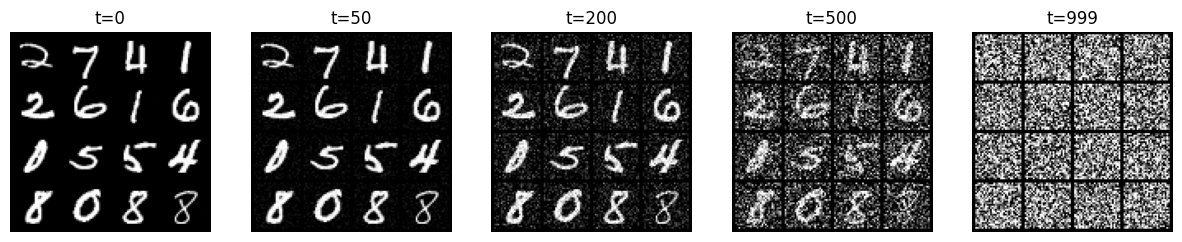

In [7]:
T = cfg.T
betas = make_beta_schedule(T, cfg.schedule, cfg.beta_start, cfg.beta_end).to(device)          # (T,)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)                                                     # (T,)

sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

def q_sample(x0, t, noise=None):
    # x_t = sqrt(a_bar_t)*x0 + sqrt(1-a_bar_t)*eps
    if noise is None:
        noise = torch.randn_like(x0)
    return (extract(sqrt_alphas_bar, t, x0.shape) * x0 +
            extract(sqrt_one_minus_alphas_bar, t, x0.shape) * noise), noise

@torch.no_grad()
def show_noising_steps(x0, steps=(0, 50, 200, 500, 999)):
    x0 = x0[:16].to(device)
    fig, axes = plt.subplots(1, len(steps), figsize=(3*len(steps), 3))
    for i, s in enumerate(steps):
        t = torch.full((x0.size(0),), s, device=device, dtype=torch.long)
        xt, _ = q_sample(x0, t)
        grid = utils.make_grid((xt + 1) / 2, nrow=4)
        axes[i].imshow(grid.permute(1,2,0).cpu())
        axes[i].set_title(f"t={s}")
        axes[i].axis("off")
    plt.show()

x0, _ = next(iter(train_loader))
show_noising_steps(x0)


In [8]:
import time

lr = 1e-4
epochs = 30
log_every = 100

opt = torch.optim.AdamW(model.parameters(), lr=lr)

def train_one_epoch(epoch):
    model.train()
    total_loss = 0.0
    n = 0

    epoch_start = time.time()
    last_log_time = time.time()

    for step, (x0, _) in enumerate(train_loader, start=1):
        step_start = time.time()

        x0 = x0.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device, dtype=torch.long)
        xt, noise = q_sample(x0, t)

        pred = model(xt, t)
        '''
        pred: 모델이 예측한 노이즈 ε̂
        noise: 실제로 섞였던 노이즈 ε
        '''
        loss = F.mse_loss(pred, noise)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        step_time = time.time() - step_start

        total_loss += loss.item() * x0.size(0)
        n += x0.size(0)
        if step % log_every == 0:
            now = time.time()
            avg_step_time = (now - last_log_time) / log_every
            last_log_time = now

            print(
                f"[epoch {epoch:02d} | step {step:05d}] "
                f"loss={loss.item():.4f} | "
                f"step_time={step_time*1000:.1f} ms | "
                f"avg_step_time={avg_step_time*1000:.1f} ms"
            )

    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / n

    print(
        f"[epoch {epoch:02d} DONE] "
        f"avg_loss={avg_loss:.4f} | "
        f"epoch_time={epoch_time:.1f} s"
    )

    return avg_loss

for ep in range(1, epochs + 1):
    train_one_epoch(ep)

os.makedirs("./ckpt", exist_ok=True)
torch.save(model.state_dict(), "./ckpt/ddpm_mnist_unet.pt")
print("saved:", "./ckpt/ddpm_mnist_unet.pt")


[epoch 01 | step 00100] loss=0.1098 | step_time=15.2 ms | avg_step_time=36.6 ms
[epoch 01 | step 00200] loss=0.0748 | step_time=14.5 ms | avg_step_time=33.1 ms
[epoch 01 | step 00300] loss=0.0777 | step_time=16.5 ms | avg_step_time=33.2 ms
[epoch 01 | step 00400] loss=0.0745 | step_time=16.0 ms | avg_step_time=33.5 ms
[epoch 01 DONE] avg_loss=0.1117 | epoch_time=16.0 s
[epoch 02 | step 00100] loss=0.0630 | step_time=17.0 ms | avg_step_time=33.9 ms
[epoch 02 | step 00200] loss=0.0665 | step_time=15.5 ms | avg_step_time=33.0 ms
[epoch 02 | step 00300] loss=0.0662 | step_time=15.0 ms | avg_step_time=33.3 ms
[epoch 02 | step 00400] loss=0.0650 | step_time=15.0 ms | avg_step_time=33.4 ms
[epoch 02 DONE] avg_loss=0.0628 | epoch_time=15.6 s
[epoch 03 | step 00100] loss=0.0563 | step_time=15.7 ms | avg_step_time=33.3 ms
[epoch 03 | step 00200] loss=0.0682 | step_time=16.2 ms | avg_step_time=33.6 ms
[epoch 03 | step 00300] loss=0.0560 | step_time=16.0 ms | avg_step_time=33.5 ms
[epoch 03 | step

In [ ]:
import os
import torch

def save_model(model, path: str):
    os.makedirs(os.path.dirname(path) or ".", exist_ok=True)
    torch.save(model.state_dict(), path)
    print(f"[saved] {path}")

def load_model(model, path: str, device: str):
    assert os.path.exists(path), f"checkpoint not found: {path}"
    state = torch.load(path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print(f"[loaded] {path}")
    return model

In [ ]:
model = UNet(
    base_ch=64,
    tdim=128,
    dropout=0.1,
    attn_levels=("mid", "14"),
).to(device)

model = load_model(model, "./ckpt/ddpm_mnist_unet.pt", device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0146125555..1.0198109].


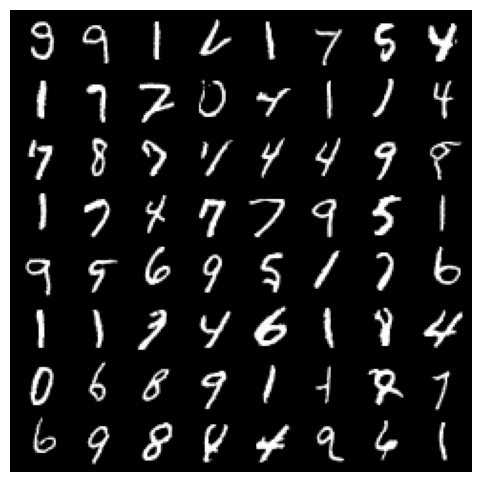

In [9]:
# posterior variance (DDPM)
alphas_bar_prev = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]], dim=0)
posterior_var = betas * (1.0 - alphas_bar_prev) / (1.0 - alphas_bar)

@torch.no_grad()
def p_sample(x_t, t):
    """
    x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-a_bar_t) * eps_theta) + sigma_t * z
    """
    b = x_t.size(0)
    t_vec = torch.full((b,), t, device=device, dtype=torch.long)

    eps_pred = model(x_t, t_vec)

    beta_t = betas[t]
    alpha_t = alphas[t]
    a_bar_t = alphas_bar[t]

    coef1 = 1.0 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1.0 - a_bar_t)

    mean = coef1 * (x_t - coef2 * eps_pred)

    if t == 0:
        return mean
    else:
        noise = torch.randn_like(x_t)
        var = posterior_var[t]
        return mean + torch.sqrt(var) * noise

@torch.no_grad()
def sample(n=64):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    for t in reversed(range(T)):
        x = p_sample(x, t)
    return x

x_gen = sample(64)
grid = utils.make_grid((x_gen + 1) / 2, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2441605..2.7780921].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.358301..2.2415564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9700142..1.7851306].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5631324..1.4810847].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18804091..1.1293013].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.013055325..1.0130556].


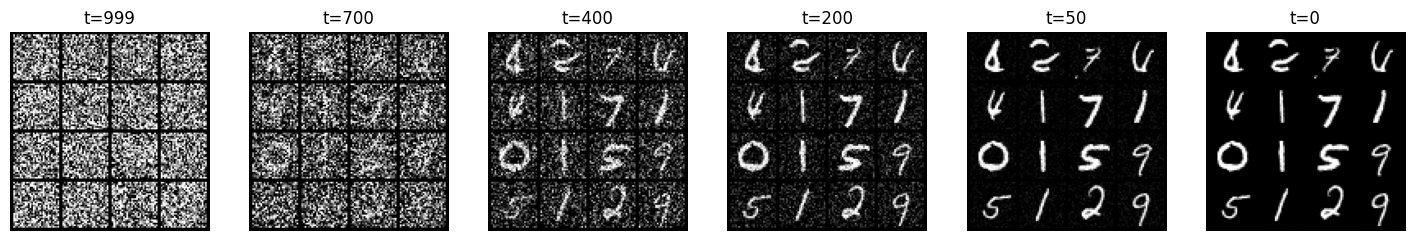

In [10]:
@torch.no_grad()
def sample_with_snapshots(n=16, snap_ts=(999, 700, 400, 200, 50, 0)):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    snaps = {}

    for t in reversed(range(T)):
        if t in snap_ts:
            snaps[t] = x.detach().clone()
        x = p_sample(x, t)

    snaps[0] = x.detach().clone()
    return snaps

snaps = sample_with_snapshots(n=16, snap_ts=(999, 700, 400, 200, 50, 0))

fig, axes = plt.subplots(1, len(snaps), figsize=(3*len(snaps), 3))
for i, t in enumerate(sorted(snaps.keys(), reverse=True)):
    grid = utils.make_grid((snaps[t] + 1) / 2, nrow=4)
    axes[i].imshow(grid.permute(1,2,0).cpu())
    axes[i].set_title(f"t={t}")
    axes[i].axis("off")
plt.show()
